In [16]:
from ect import Config
from ect.helpers import UnimodalGenerator, Mode

from matplotlib import pyplot as plt
from typing import Callable

from matplotlib.cm import grey, magma

from ect import ilogpolar_new

2024-06-11 09:18:43.536 | DEBUG    | ect.maps.logpolar_new:logpolar:50 - Running logpolar transform in offset mode offset=5
2024-06-11 09:18:43.537 | DEBUG    | ect.maps.logpolar_new:logpolar:63 - Applying bilinear pixel mapping


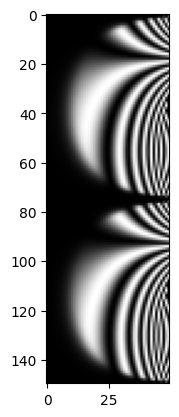

In [17]:
m = Mode(30, 45, 1)

gen = UnimodalGenerator(m, dsize=(150, 50), offset=5)

img = gen.generate()

plt.imshow(img, cmap=grey)

2024-06-11 09:18:43.635 | DEBUG    | ect.maps.ilogpolar_new:ilogpolar:78 - Running logpolar transform in offset mode
2024-06-11 09:18:43.637 | DEBUG    | ect.maps.ilogpolar_new:ilogpolar:94 - Applying bilinear pixel mapping


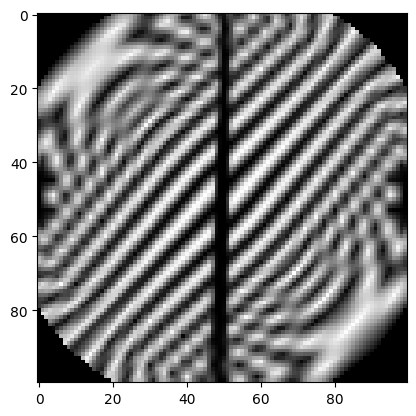

In [18]:
inv = ilogpolar_new(img, (100, 100), 50, cfg=Config(offset_value_px=0))

plt.imshow(inv, cmap=grey)

In [19]:
import numpy as np

from ect.helpers import vectors
from ect.transforms.utils_new import antialias
from ect.transforms.fect_new import _antialias

from icecream import ic

# from .utils import *
# from ..filters import sigmoid

def ect(
    image: np.ndarray, 
    cfg: Config = Config()
) -> np.ndarray:
    '''
    An O(n^4) direct implementation of ECT
    '''

    V = image.shape[0]
    U = image.shape[1]
    out = np.zeros(image.shape[:2], dtype=complex)
    kernel = np.zeros(image.shape[:2], dtype=complex)
    
    rhos, phis, xs, ys = vectors((V//2, U), cfg)
    rhos = rhos[:, U:]
    xs = xs[:, U:]
    ys = ys[:, U:]

    if cfg.mode == "offset":
        offset_bool: np.ndarray = (xs > 0).astype(int) 
        offset: np.ndarray = (offset_bool*2 - 1) * cfg.offset_value_px
        xs += offset

    if cfg.antialias:
        cfg.antialias_params = _antialias(xs, ys, (U, V), cfg.antialias_factors)

    for u in range(-U//2, U//2):
        # print("Progress: {}/{}".format(u, U))
        for v in range(-V//2, V//2):
            kvector = xs*(u)/U + ys*(v)/V
            # calculate kernel
            kernel = np.exp(2*rhos-2*np.pi*1j*kvector)
            kernel = antialias(kernel, cfg.antialias_params)

            out[v, u] = (image*kernel).sum().sum()

    return out



In [20]:
from ect.transforms import dect as libect

transformed = libect(img, cfg=Config(antialias_factors=[.11, .11]))

100%|██████████| 50/50 [00:01<00:00, 30.43it/s]


In [21]:
def center(inp: np.ndarray, invfunc: Callable[[np.ndarray], np.ndarray]) -> np.ndarray:
    X, Y = inp.shape
    inp = invfunc(inp)
    out = np.zeros_like(inp)
    out[:X//2, :Y//2] = inp[X//2:, Y//2:]
    out[X//2:, :Y//2] = inp[:X//2, Y//2:]
    out[X//2:, Y//2:] = inp[:X//2, :Y//2]
    out[:X//2, Y//2:] = inp[X//2:, :Y//2]
    return out

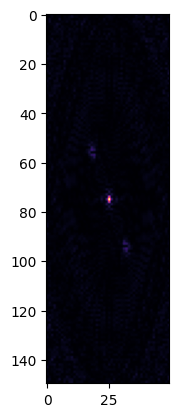

In [22]:
from ect import complex_to_hsv

disp = complex_to_hsv(transformed)

plt.imshow(center(transformed, np.abs), cmap=magma)